# **CIFAR-10 - Object Recognition in Images**

Identify the subject of 60,000 labeled images

## **Description**

CIFAR-10  is an established computer-vision dataset used for object recognition. It is a subset of the 80 million tiny images dataset and consists of 60,000 32x32 color images containing one of 10 object classes, with 6000 images per class. It was collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton.

There are 50,000 training images and 10,000 test images in the official data. We have preserved the train/test split from the original dataset.  The provided files are:

**train.7z** - a folder containing the training images in png format
**test.7z** - a folder containing the test images in png format
**trainLabels.csv** - the training labels

To discourage certain forms of cheating (such as hand labeling) we have added 290,000 junk images in the test set. These images are ignored in the scoring. We have also made trivial modifications to the official 10,000 test images to prevent looking them up by file hash. These modifications should not appreciably affect the scoring. You should predict labels for all 300,000 images.

The label classes in the dataset are:

* airplane
* automobile
* bird
* cat
* deer
* dog
* frog
* horse
* ship
* truck

The classes are completely mutually exclusive. There is no overlap between automobiles and trucks. "Automobile" includes sedans, SUVs, things of that sort. "Truck" includes only big trucks. Neither includes pickup trucks.

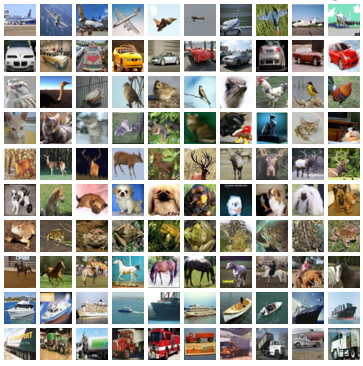

# **Extracting Dataset using Kaggle API**

In [8]:
# Install the Kaggle Library
!pip install Kaggle


In [9]:
# Configuring the path of Kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

**Install necessary Libraries**

In [10]:
pip install gradio

In [11]:
!pip install py7zr

## **Import the Libraries**

##**Importing the Datasets from Kaggle**

In [12]:
!kaggle competitions download -c cifar-10

 99% 706M/715M [00:05<00:00, 92.3MB/s]
100% 715M/715M [00:05<00:00, 134MB/s] 


In [13]:
# Extracting the compressed dataset
from zipfile import ZipFile
file_name = "/content/cifar-10.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')


Done


In [14]:
!ls

cifar-10.zip  kaggle.json  sample_data	sampleSubmission.csv  test.7z  train.7z  trainLabels.csv


In [15]:
import py7zr
archive = py7zr.SevenZipFile('/content/train.7z', mode="r")
archive.extractall()  # archive.extractall(path="/content/Training Data")
archive.close()

In [16]:
!ls

cifar-10.zip  sample_data	    test.7z  train.7z
kaggle.json   sampleSubmission.csv  train    trainLabels.csv


##**Import the Libraries**

In [17]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import cv2
from google.colab.patches import cv2_imshow
import gradio as gr


In [18]:
file_names = os.listdir('/content/train')

In [19]:
type(file_names)

list

In [20]:
len(file_names)

50000

In [21]:
print("First five names of: ", file_names[0:5])
print("Last five names of: ",  file_names[-5:])

First five names of:  ['45400.png', '46953.png', '34240.png', '4358.png', '37659.png']
Last five names of:  ['11613.png', '43773.png', '2767.png', '14009.png', '28650.png']


##**Labels Processing**

In [22]:
# Loading the dataset into a pandas DataFrame
labels_df = pd.read_csv('/content/trainLabels.csv')  # Use this to identify issues

In [23]:
# Display the first few rows
print("First 10 rows of the dataset:")
labels_df.head(10)

First 10 rows of the dataset:


,id,label
0,1,frog
1,2,truck
2,3,truck
3,4,deer
4,5,automobile
5,6,automobile
6,7,bird
7,8,horse
8,9,ship
9,10,cat


In [24]:
# Display the last few rows
print("Last 10 rows of the dataset:")
labels_df.tail(10)

Last 10 rows of the dataset:


,id,label
49990,49991,deer
49991,49992,bird
49992,49993,airplane
49993,49994,automobile
49994,49995,airplane
49995,49996,bird
49996,49997,frog
49997,49998,truck
49998,49999,automobile
49999,50000,automobile


In [25]:
# Checking the shape of the dataset
labels_df.shape   # Outputs the number of rows and columns in the dataset.

(50000, 2)

In [26]:
labels_df[labels_df["id"] == 19628]

,id,label
19627,19628,deer


If we notice the **image(id)** are not in order while that of the **label(id)** are in order so we have to make it in order

In [27]:
# Checking of distribution for each label
labels_df['label'].value_counts()

,count
label,
frog,5000
truck,5000
deer,5000
automobile,5000
bird,5000
horse,5000
ship,5000
cat,5000
dog,5000


In [28]:
# Coverting using OneHot Encoding
df = pd.DataFrame({"label": labels_df["label"]})

one_hot_encoded = pd.get_dummies(df["label"])     # Apply One-Hot Encoding

print(one_hot_encoded)

       airplane  automobile   bird    cat   deer    dog   frog  horse   ship  \
0         False       False  False  False  False  False   True  False  False   
1         False       False  False  False  False  False  False  False  False   
2         False       False  False  False  False  False  False  False  False   
3         False       False  False  False   True  False  False  False  False   
4         False        True  False  False  False  False  False  False  False   
...         ...         ...    ...    ...    ...    ...    ...    ...    ...   
49995     False       False   True  False  False  False  False  False  False   
49996     False       False  False  False  False  False   True  False  False   
49997     False       False  False  False  False  False  False  False  False   
49998     False        True  False  False  False  False  False  False  False   
49999     False        True  False  False  False  False  False  False  False   

       truck  
0      False  
1       T

In [29]:
# Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
onehotencoded = encoder.fit_transform(labels_df)

print(onehotencoded)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 1.]
 [0. 0. 1. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [30]:
# Manually converting the label to numerical variable
labels_dict = {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}

labels = [labels_dict[i] for i in labels_df['label']]

In [31]:
print("First five names of: ", labels[0:5])
print("Last five names of: ",  labels[-5:])

First five names of:  [6, 9, 9, 4, 1]
Last five names of:  [2, 6, 9, 1, 1]


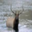

In [32]:
# Display the image
img = cv2.imread('/content/train/19628.png')
cv2_imshow(img)

In [33]:
labels_df[labels_df["id"] == 14097]

,id,label
14096,14097,automobile


In [34]:
id_list = list(labels_df["id"])

In [35]:
print("First five names of: ", id_list[0:5])
print("Last five names of: ",  id_list[-5:])

First five names of:  [1, 2, 3, 4, 5]
Last five names of:  [49996, 49997, 49998, 49999, 50000]


## **Image Processing**

In [36]:
# Convert images to numpy arrays
train_data_folder = "/content/train"

data = []

for id in id_list:

  image = Image.open(os.path.join(train_data_folder, str(id) + ".png"))
  image = np.array(image)
  data.append(image)



In [37]:
type(data)

list

In [38]:
len(data)

50000

In [39]:
type(data[0])

numpy.ndarray

In [40]:
data[0].shape

(32, 32, 3)

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]], dtype=uint8)
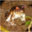

In [41]:
data[0]


In [42]:
# Convert images and labels to numpy array
X = np.array(data)
y = np.array(labels)

In [43]:
type(X)

numpy.ndarray

In [44]:
print(X.shape)
print(y.shape)

(50000, 32, 32, 3)
(50000,)


##**Splitting the Dataset into Training and Test Sets**

In [45]:
# Splitting the dataset into Training and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=32)
print("\nDataset split completed:")
print(f"Total samples: {X.shape[0]}, Training samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")



Dataset split completed:
Total samples: 50000, Training samples: 37500, Test samples: 12500


In [46]:
print(X.shape)
print(X_train.shape)
print(X_test.shape)

(50000, 32, 32, 3)
(37500, 32, 32, 3)
(12500, 32, 32, 3)


* **37500 --> Training Images**
* **12500 --> Test Images**

In [47]:
# Normalization (Scaling the values to be in range of 0 - 1)
X_train_norm = X_train / 255.0

X_test_norm = X_test / 255.0


In [48]:
print(X_train_norm)

[[[[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  ...

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.         0.         0.        ]
   [0. 

## **Building the Neural Network**

In [49]:
num_of_classes = 10

# Setting up the layers of Neural Network
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(32, 32, 3)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(num_of_classes, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [50]:
# compile the neural network
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [51]:
# Training the neural network
model.fit(X_train_norm, y_train, validation_split=0.1, epochs=10)

Epoch 1/10
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.2602 - loss: 2.0622 - val_accuracy: 0.3109 - val_loss: 1.9053
Epoch 2/10
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.3544 - loss: 1.8145 - val_accuracy: 0.3301 - val_loss: 1.8635
Epoch 3/10
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.3832 - loss: 1.7495 - val_accuracy: 0.3563 - val_loss: 1.8018
Epoch 4/10
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.3857 - loss: 1.7146 - val_accuracy: 0.3707 - val_loss: 1.7422
Epoch 5/10
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.3956 - loss: 1.6916 - val_accuracy: 0.3725 - val_loss: 1.7456
Epoch 6/10
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4056 - loss: 1.6688 - val_accuracy: 0.3808 - val_loss: 1.7107
Epoch 7/10
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.4080 - loss: 1.6649 - val_accuracy: 0.3816 - val_loss: 1.7187
Epoch 8/10
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4024 - loss: 1.6582 - 

## **ResNet50**

In [52]:
# Import necessary TensorFlow and Keras modules
from tensorflow.keras import Sequential, models, layers, optimizers     # Import Sequential model and key modules
from tensorflow.keras.applications import ResNet50                      # Import ResNet50 pre-trained model
from tensorflow.keras.layers import Dense, Dropout, Flatten             # Import Dense, Dropout, and Flatten layers
from tensorflow.keras.models import load_model                          # Import function to load saved models
from tensorflow.keras.layers import BatchNormalization                  # Import BatchNormalization for faster training
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D       # Import additional layers
from tensorflow.keras.models import Model                               # Import Model class for building custom models

In [53]:
# Load the ResNet50 model with pre-trained weights
convolutional_base = ResNet50(weights='imagenet',         # Load weights pre-trained on ImageNet
                              include_top=False,          # Remove the fully connected layers to use only convolutional layers
                              input_shape=(256, 256, 3)   # Define the input image size (256x256 pixels, 3 color channels)
                              )


# Print a summary of the ResNet50 model to check layer details
convolutional_base.summary()     # Displays the architecture of the ResNet50 model

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 64, 64, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [54]:
# Define the number of output classes (for classification)
num_of_classes = 10

# Initializes a Sequential model in which layers are stacked one after another
model = models.Sequential()

# Upsampling by increasing the spatial dimensions of the image
model.add(layers.UpSampling2D((2,2)))  # Upscales the image by 2x
model.add(layers.UpSampling2D((2,2)))  # Upscales the image by 2x again
model.add(layers.UpSampling2D((2,2)))  # Upscales the image by 2x one more time

# Add Pre-trained Model
model.add(convolutional_base)        # Adds the ResNet50 convolutional base (pre-trained on ImageNet)

# Flattening the Output
model.add(layers.Flatten())         # Converts the 2D feature maps from ResNet50 into a 1D vector to be processed by dense layers.

# First fully connected layer with batch normalization
model.add(layers.BatchNormalization())              # Normalize feature values for stable training
model.add(layers.Dense(256, activation='relu'))     # Fully connected layer with 256 neurons
model.add(layers.Dropout(0.5))                      # Dropout to prevent overfitting

# Second fully connected layer
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation='relu'))    # 128 neurons with ReLU activation
model.add(layers.Dropout(0.5))                     # Dropout (50%) to prevent overfitting

# Final output layer (Softmax for multi-class classification)
model.add(layers.BatchNormalization())                              # Normalize before final prediction
model.add(layers.Dense(num_of_classes, activation='softmax'))       # Output layer with 10 classes


In [55]:
# Compile the model
model.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5),         # Use RMSprop optimizer with a small learning rate (0.00002)
              loss='sparse_categorical_crossentropy',                   # Loss function for multi-class classification (integer labels)
              metrics=['accuracy'])                                     # Track accuracy as the performance metric

In [57]:
history = model.fit(X_train_norm, y_train, validation_split=0.1, epochs=10)

Epoch 1/10
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 364s 345ms/step - accuracy: 0.9893 - loss: 0.0641 - val_accuracy: 0.9331 - val_loss: 0.2358
Epoch 2/10
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 372s 335ms/step - accuracy: 0.9906 - loss: 0.0543 - val_accuracy: 0.9355 - val_loss: 0.2365
Epoch 3/10
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 391s 344ms/step - accuracy: 0.9922 - loss: 0.0469 - val_accuracy: 0.9296 - val_loss: 0.2795
Epoch 4/10
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 382s 344ms/step - accuracy: 0.9934 - loss: 0.0362 - val_accuracy: 0.9344 - val_loss: 0.2554
Epoch 5/10
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 382s 344ms/step - accuracy: 0.9941 - loss: 0.0337 - val_accuracy: 0.9336 - val_loss: 0.2709
Epoch 6/10
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 382s 344ms/step - accuracy: 0.9935 - loss: 0.0325 - val_accuracy: 0.9323 - val_loss: 0.2723
Epoch 7/10
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 382s 345ms/step - accuracy: 0.9944 - loss: 0.0299 - val_accuracy: 0.9400 - val_loss: 0.2583
Epoch 8/10
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 364s 345ms/step - ac

In [58]:
loss, accuracy = model.evaluate(X_test_norm, y_test)
print(f'Test accuracy: {accuracy * 100:.2f}%')

391/391 ━━━━━━━━━━━━━━━━━━━━ 43s 109ms/step - accuracy: 0.9402 - loss: 0.2636
Test accuracy: 94.10%


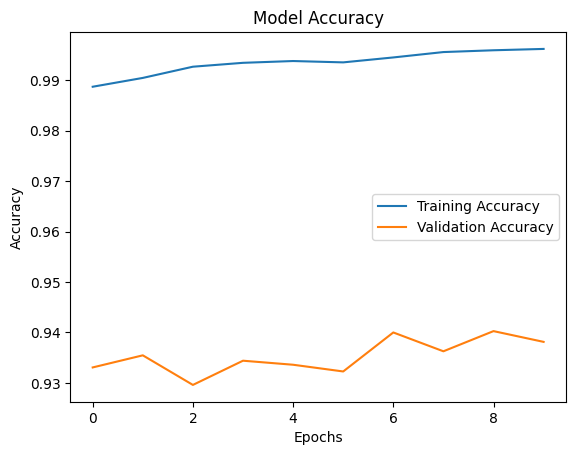

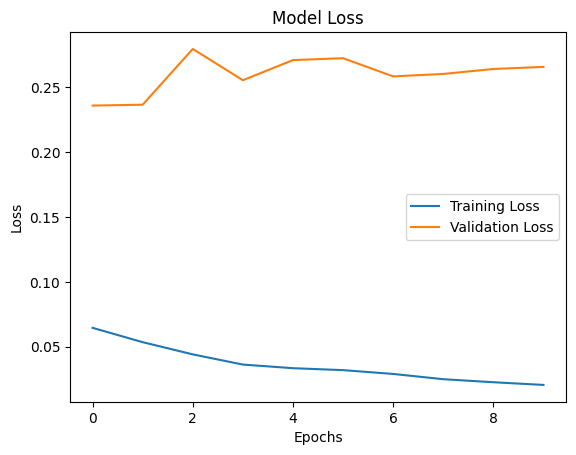

In [61]:
his = history

# Accuracy Plot
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()


# Loss Plot
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.show()

In [67]:
# Define class labels for CIFAR-10 dataset
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                'dog', 'frog', 'horse', 'ship', 'truck']

In [68]:
model = model.save("trained_model.h5")

In [69]:
# Load the trained CIFAR-10 model
model = load_model("trained_model.h5")  # Ensure the model file exists

## **Predictive System**

Path of the image to be predicted: /content/deer.jfif


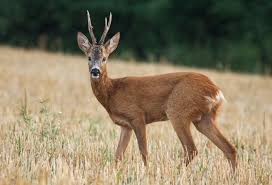

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step

Prediction Probabilities: [[1.7318960e-04 1.0482774e-04 1.1454937e-03 1.1195299e-04 9.9758315e-01
  2.0654518e-04 1.1457532e-04 3.4546095e-04 1.4595005e-04 6.8906360e-05]]

Predicted Class Label Index: 4

The image is classified as: **deer**


In [70]:
# Enter the path of Image
input_image_path = input("Path of the image to be predicted: ")

# Read the image entered
input_image = cv2.imread(input_image_path)

# Display the Image (for Google Colab users)
cv2_imshow(input_image)

# Resize the image to match the CIFAR-10 input shape (32x32 pixels)
input_image_resized = cv2.resize(input_image, (32, 32))

# Normalization (Scaling the values to be in range of 0 - 1)
input_image_scaled = input_image_resized / 255

# Reshaping the image
image_reshaped = np.expand_dims(input_image_scaled, axis=0)

# Predict the image class
input_prediction = model.predict(image_reshaped)

# Get the class label with the highest probability
input_pred_label = np.argmax(input_prediction)


print("\nPrediction Probabilities:", input_prediction)
print("\nPredicted Class Label Index:", input_pred_label)
print(f"\nThe image is classified as: **{class_labels[input_pred_label]}**")

Enter the image path: /content/automobile.jfif


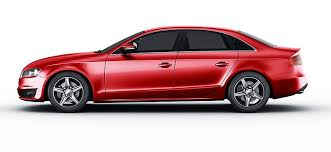

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step

Prediction Probabilities: [[1.7743581e-04 9.9953389e-01 8.8139632e-06 2.8801263e-05 2.8773562e-05
  2.5076148e-05 7.2619499e-05 2.8291533e-05 4.0623145e-05 5.5829507e-05]]

Predicted Class Label Index: 1

The image is classified as: **automobile**


'automobile'

In [71]:
def predict_cifar10_image(image_path):
    """
    Predict the class of a given image using the trained CIFAR-10 model.

    Parameters:
    - image_path (str): Path to the image file.

    Returns:
    - Predicted class label
    """

    # Read the image
    input_image = cv2.imread(image_path)

    if input_image is None:
        print("Error: Unable to read the image. Check the file path.")
        return

    # Display the Image (for Google Colab users)
    cv2_imshow(input_image)

    # Resize the image to match the CIFAR-10 input shape (32x32 pixels)
    input_image_resized = cv2.resize(input_image, (32, 32))

    # Normalize pixel values (scale to 0 - 1 range)
    input_image_scaled = input_image_resized / 255.0

    # Reshape the image to fit model input dimensions
    image_reshaped = np.reshape(input_image_scaled, [1, 32, 32, 3])

    # Predict the image class
    input_prediction = model.predict(image_reshaped)

    # Get the class label with the highest probability
    input_pred_label = np.argmax(input_prediction)

    # Display the prediction results
    print("\nPrediction Probabilities:", input_prediction)
    print("\nPredicted Class Label Index:", input_pred_label)
    print(f"\nThe image is classified as: **{class_labels[input_pred_label]}**")

    return class_labels[input_pred_label]

# Request user input for the image path
input_image_path = input("Enter the image path: ")

# Predict the class of the input image
predict_cifar10_image(input_image_path)


Enter the image path: /content/airplane.jfif


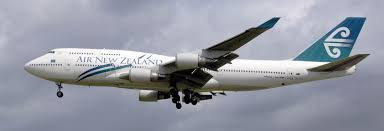

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step

Prediction Probabilities: [[9.9930608e-01 1.7073640e-05 7.4117073e-05 6.6700624e-05 9.0535155e-05
  1.4253859e-04 9.4678639e-05 8.8771936e-05 6.3018830e-05 5.6432262e-05]]

Predicted Class Label Index: 0

The image is classified as: **airplane**


'airplane'

In [72]:
def predict_cifar10_image(image_path):
    """
    Predict the class of a given image using the trained CIFAR-10 model.

    Parameters:
    - image_path (str): Path to the image file.

    Returns:
    - Predicted class label
    """

    # Read the image
    input_image = cv2.imread(image_path)

    if input_image is None:
        print("Error: Unable to read the image. Check the file path.")
        return

    # Display the Image (for Google Colab users)
    cv2_imshow(input_image)

    # Resize the image to match the CIFAR-10 input shape (32x32 pixels)
    input_image_resized = cv2.resize(input_image, (32, 32))

    # Normalize pixel values (scale to 0 - 1 range)
    input_image_scaled = input_image_resized / 255.0

    # Reshape the image to fit model input dimensions
    image_reshaped = np.reshape(input_image_scaled, [1, 32, 32, 3])

    # Predict the image class
    input_prediction = model.predict(image_reshaped)

    # Get the class label with the highest probability
    input_pred_label = np.argmax(input_prediction)

    # Display the prediction results
    print("\nPrediction Probabilities:", input_prediction)
    print("\nPredicted Class Label Index:", input_pred_label)
    print(f"\nThe image is classified as: **{class_labels[input_pred_label]}**")

    return class_labels[input_pred_label]

# Request user input for the image path
input_image_path = input("Enter the image path: ")

# Predict the class of the input image
predict_cifar10_image(input_image_path)


Enter the image path: /content/bird.jfif


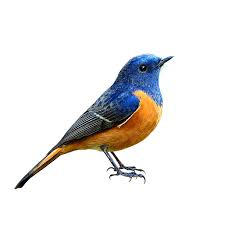

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step

Prediction Probabilities: [[3.1689866e-04 1.3308231e-05 9.9925750e-01 1.1688922e-04 2.9934781e-05
  3.2175081e-05 4.8523703e-05 7.4180643e-05 7.1917617e-05 3.8737155e-05]]

Predicted Class Label Index: 2

The image is classified as: **bird**


'bird'

In [73]:
def predict_cifar10_image(image_path):
    """
    Predict the class of a given image using the trained CIFAR-10 model.

    Parameters:
    - image_path (str): Path to the image file.

    Returns:
    - Predicted class label
    """

    # Read the image
    input_image = cv2.imread(image_path)

    if input_image is None:
        print("Error: Unable to read the image. Check the file path.")
        return

    # Display the Image (for Google Colab users)
    cv2_imshow(input_image)

    # Resize the image to match the CIFAR-10 input shape (32x32 pixels)
    input_image_resized = cv2.resize(input_image, (32, 32))

    # Normalize pixel values (scale to 0 - 1 range)
    input_image_scaled = input_image_resized / 255.0

    # Reshape the image to fit model input dimensions
    image_reshaped = np.reshape(input_image_scaled, [1, 32, 32, 3])

    # Predict the image class
    input_prediction = model.predict(image_reshaped)

    # Get the class label with the highest probability
    input_pred_label = np.argmax(input_prediction)

    # Display the prediction results
    print("\nPrediction Probabilities:", input_prediction)
    print("\nPredicted Class Label Index:", input_pred_label)
    print(f"\nThe image is classified as: **{class_labels[input_pred_label]}**")

    return class_labels[input_pred_label]

# Request user input for the image path
input_image_path = input("Enter the image path: ")

# Predict the class of the input image
predict_cifar10_image(input_image_path)


##**Deploying with Gradio**

In [82]:
def predict_image(image):
    """Predict if the uploaded image belongs to one of the CIFAR-10 categories."""

    if image is None:
        return "Error: No image uploaded!"

    # Convert image to OpenCV format (BGR)
    input_image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    # Resize, normalize, and reshape image
    input_image_resized = cv2.resize(input_image, (32, 32))
    input_image_scaled = input_image_resized / 255.0
    image_reshaped = np.expand_dims(input_image_scaled, axis=0)

    # Predict the class
    input_prediction = model.predict(image_reshaped)
    label_index = np.argmax(input_prediction)

    # Define class labels
    class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                    'dog', 'frog', 'horse', 'ship', 'truck']

    return f"The image representation is a: {class_labels[label_index]}"

# Create Gradio Interface
interface = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="numpy"),
    outputs="text",
    title="CIFAR-10 Image Classifier",
    description="Upload an image and the model will classify it."
)

interface.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a08b5aabea8eacb355.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
